# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

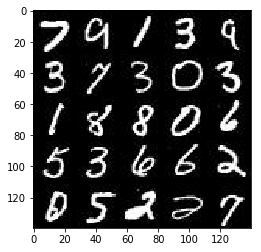

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

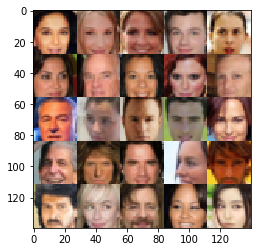

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="images_real")
    z = tf.placeholder(tf.float32, shape=(None, z_dim), name="latent")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [47]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*1024)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x1024
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 4x4x512 now
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 7x7x256 now
        
        x4 = tf.layers.conv2d_transpose(x3, 256, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 7x7x256 now
        
        x5 = tf.layers.conv2d_transpose(x4, 128, 5, strides=2, padding='same')
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(alpha * x5, x5)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x5, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [48]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    images_fake = generator(input_z, out_channel_dim, is_train=True)
    _, d_logits_real = discriminator(input_real, reuse=False)
    _, d_logits_fake = discriminator(images_fake, reuse=True)
    
    # Calculate losses
    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [49]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get variables
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Define optimization operations
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [50]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [55]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    images_real, z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(images_real, z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        i = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={images_real: batch_images, z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z: batch_z, lr: learning_rate})
                if i % 30 == 0:
                    show_generator_output(sess, 25, z, image_channels, data_image_mode)
                    train_loss_d = sess.run(d_loss, {z: batch_z, images_real: batch_images})
                    train_loss_g = g_loss.eval({z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}...".format(i),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                i += 1
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

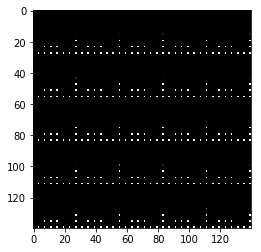

Epoch 1/2... Batch 0... Discriminator Loss: 21.0822... Generator Loss: 0.0000


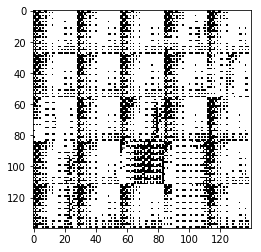

Epoch 1/2... Batch 30... Discriminator Loss: 3.4438... Generator Loss: 2.7564


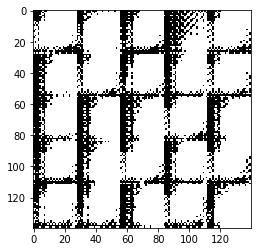

Epoch 1/2... Batch 60... Discriminator Loss: 2.4977... Generator Loss: 0.2441


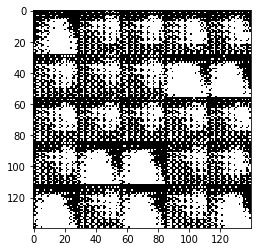

Epoch 1/2... Batch 90... Discriminator Loss: 3.8951... Generator Loss: 0.1955


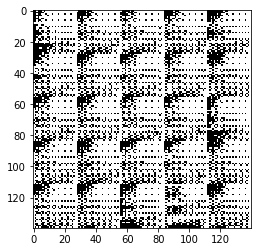

Epoch 1/2... Batch 120... Discriminator Loss: 1.4800... Generator Loss: 0.6703


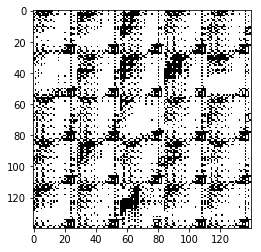

Epoch 1/2... Batch 150... Discriminator Loss: 3.2372... Generator Loss: 0.0680


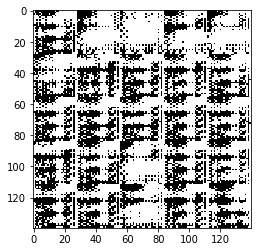

Epoch 1/2... Batch 180... Discriminator Loss: 1.1311... Generator Loss: 0.7081


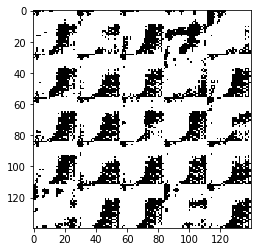

Epoch 1/2... Batch 210... Discriminator Loss: 1.2534... Generator Loss: 0.6453


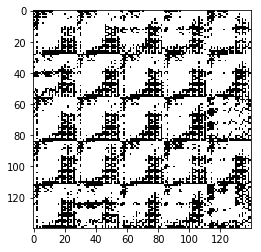

Epoch 1/2... Batch 240... Discriminator Loss: 1.2835... Generator Loss: 1.9558


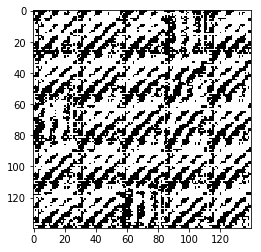

Epoch 1/2... Batch 270... Discriminator Loss: 1.3091... Generator Loss: 0.5056


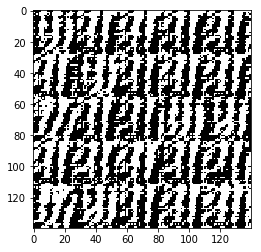

Epoch 1/2... Batch 300... Discriminator Loss: 1.0874... Generator Loss: 1.1933


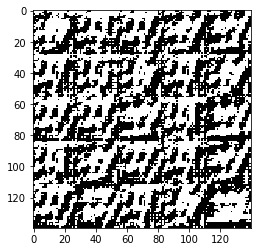

Epoch 1/2... Batch 330... Discriminator Loss: 1.4224... Generator Loss: 0.5467


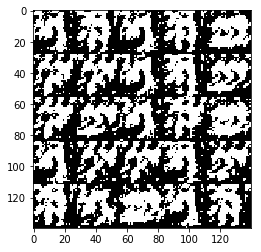

Epoch 1/2... Batch 360... Discriminator Loss: 1.3330... Generator Loss: 0.7152


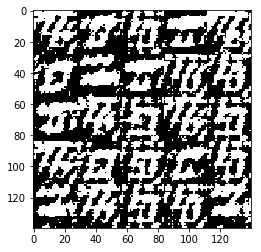

Epoch 1/2... Batch 390... Discriminator Loss: 1.3732... Generator Loss: 0.9004


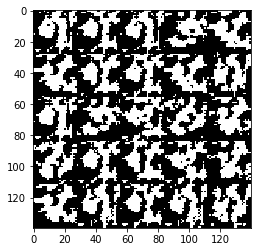

Epoch 1/2... Batch 420... Discriminator Loss: 1.2113... Generator Loss: 1.0613


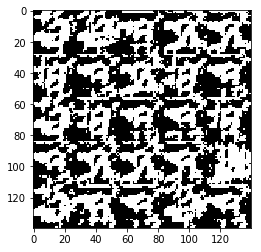

Epoch 1/2... Batch 450... Discriminator Loss: 1.3478... Generator Loss: 1.1873


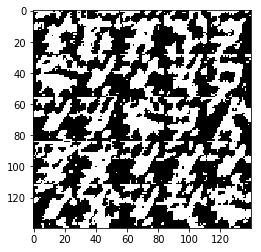

Epoch 1/2... Batch 480... Discriminator Loss: 1.3391... Generator Loss: 0.9582


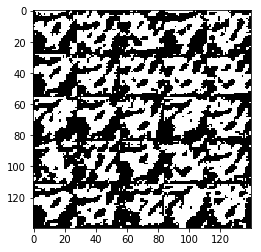

Epoch 1/2... Batch 510... Discriminator Loss: 1.3578... Generator Loss: 0.8953


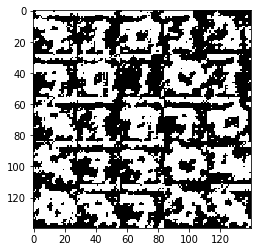

Epoch 1/2... Batch 540... Discriminator Loss: 1.5280... Generator Loss: 0.9566


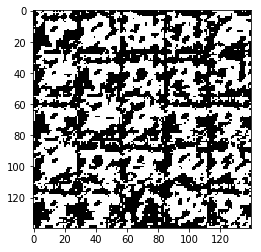

Epoch 1/2... Batch 570... Discriminator Loss: 1.3784... Generator Loss: 0.9516


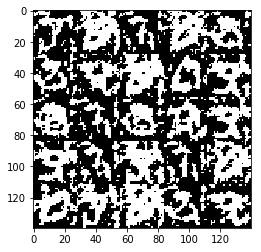

Epoch 1/2... Batch 600... Discriminator Loss: 1.3634... Generator Loss: 0.7024


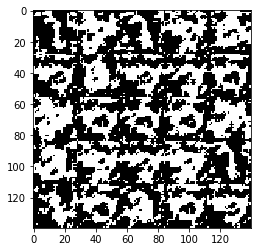

Epoch 1/2... Batch 630... Discriminator Loss: 1.4167... Generator Loss: 0.7464


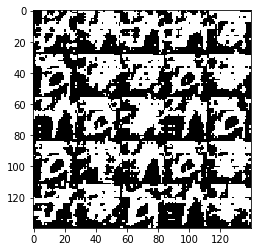

Epoch 1/2... Batch 660... Discriminator Loss: 1.3311... Generator Loss: 0.8137


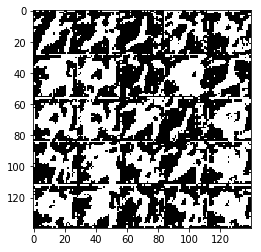

Epoch 1/2... Batch 690... Discriminator Loss: 1.3516... Generator Loss: 0.6616


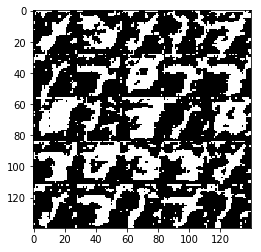

Epoch 1/2... Batch 720... Discriminator Loss: 1.3979... Generator Loss: 0.9870


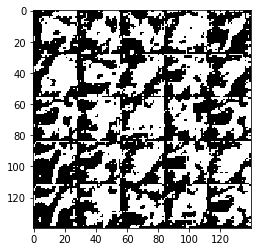

Epoch 1/2... Batch 750... Discriminator Loss: 1.4182... Generator Loss: 0.5595


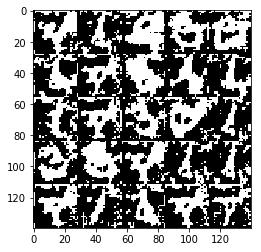

Epoch 1/2... Batch 780... Discriminator Loss: 1.4597... Generator Loss: 0.5119


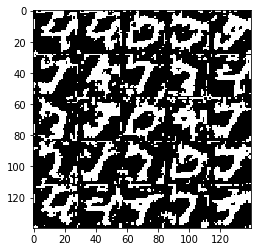

Epoch 1/2... Batch 810... Discriminator Loss: 1.3836... Generator Loss: 0.6904


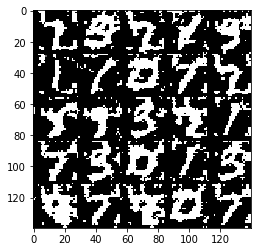

Epoch 1/2... Batch 840... Discriminator Loss: 1.3998... Generator Loss: 0.6945


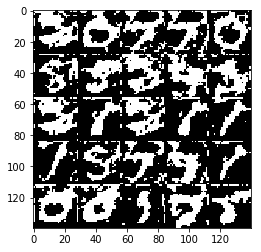

Epoch 1/2... Batch 870... Discriminator Loss: 1.4017... Generator Loss: 0.9098


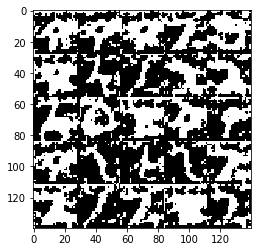

Epoch 1/2... Batch 900... Discriminator Loss: 1.3503... Generator Loss: 0.9724


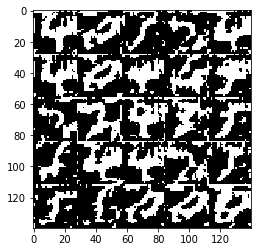

Epoch 1/2... Batch 930... Discriminator Loss: 1.4133... Generator Loss: 0.6129


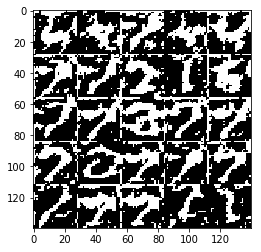

Epoch 2/2... Batch 960... Discriminator Loss: 1.3954... Generator Loss: 0.6962


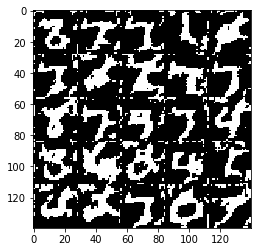

Epoch 2/2... Batch 990... Discriminator Loss: 1.3636... Generator Loss: 0.8255


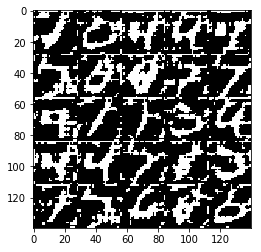

Epoch 2/2... Batch 1020... Discriminator Loss: 1.3182... Generator Loss: 0.8308


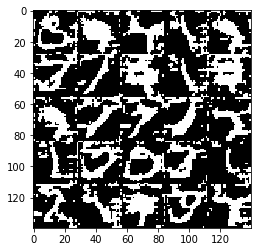

Epoch 2/2... Batch 1050... Discriminator Loss: 1.4134... Generator Loss: 0.7294


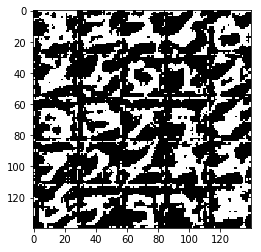

Epoch 2/2... Batch 1080... Discriminator Loss: 1.5637... Generator Loss: 0.4220


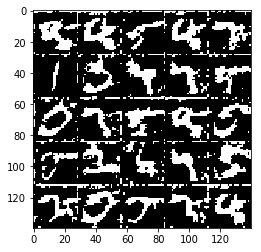

Epoch 2/2... Batch 1110... Discriminator Loss: 1.3597... Generator Loss: 0.6983


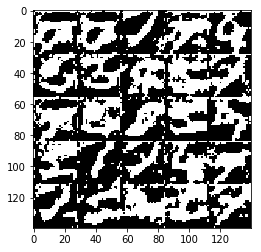

Epoch 2/2... Batch 1140... Discriminator Loss: 1.3882... Generator Loss: 0.8026


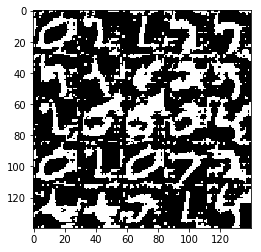

Epoch 2/2... Batch 1170... Discriminator Loss: 1.4506... Generator Loss: 0.9986


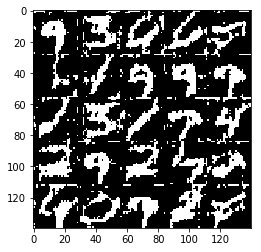

Epoch 2/2... Batch 1200... Discriminator Loss: 1.3724... Generator Loss: 0.7704


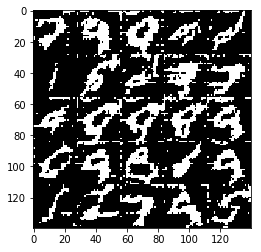

Epoch 2/2... Batch 1230... Discriminator Loss: 1.4142... Generator Loss: 0.9208


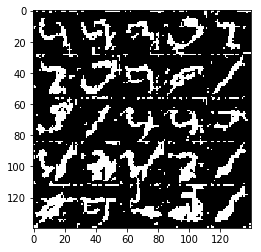

Epoch 2/2... Batch 1260... Discriminator Loss: 1.3931... Generator Loss: 0.7175


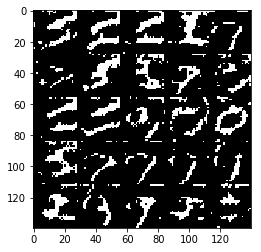

Epoch 2/2... Batch 1290... Discriminator Loss: 1.4044... Generator Loss: 0.7861


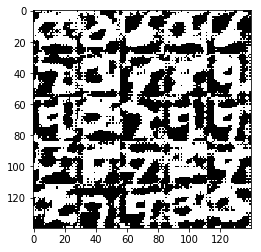

Epoch 2/2... Batch 1320... Discriminator Loss: 1.5037... Generator Loss: 0.4171


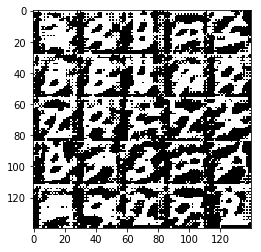

Epoch 2/2... Batch 1350... Discriminator Loss: 1.3605... Generator Loss: 0.8010


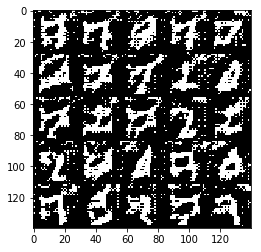

Epoch 2/2... Batch 1380... Discriminator Loss: 1.4442... Generator Loss: 0.6012


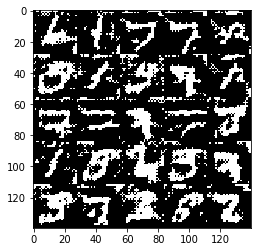

Epoch 2/2... Batch 1410... Discriminator Loss: 1.3737... Generator Loss: 0.7469


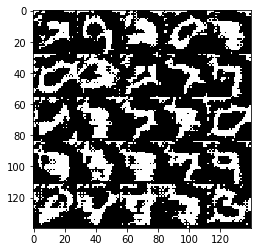

Epoch 2/2... Batch 1440... Discriminator Loss: 1.3939... Generator Loss: 0.7708


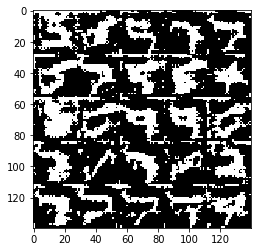

Epoch 2/2... Batch 1470... Discriminator Loss: 1.3843... Generator Loss: 0.6932


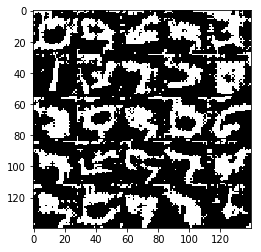

Epoch 2/2... Batch 1500... Discriminator Loss: 1.3767... Generator Loss: 0.7928


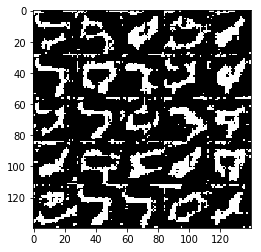

Epoch 2/2... Batch 1530... Discriminator Loss: 1.3839... Generator Loss: 0.7467


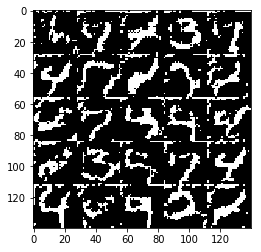

Epoch 2/2... Batch 1560... Discriminator Loss: 1.4225... Generator Loss: 0.6995


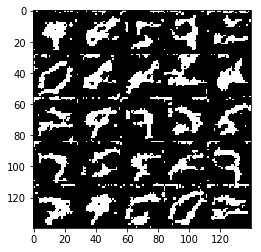

Epoch 2/2... Batch 1590... Discriminator Loss: 1.3849... Generator Loss: 0.8218


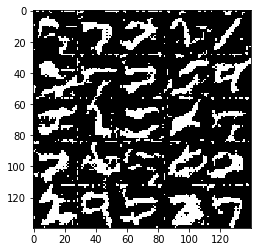

Epoch 2/2... Batch 1620... Discriminator Loss: 1.3945... Generator Loss: 0.6897


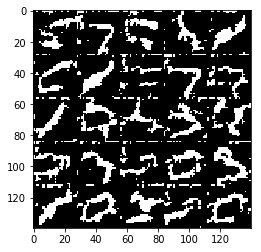

Epoch 2/2... Batch 1650... Discriminator Loss: 1.4311... Generator Loss: 0.6118


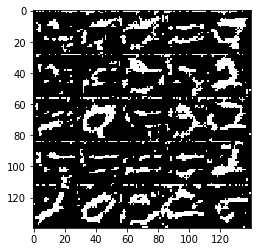

Epoch 2/2... Batch 1680... Discriminator Loss: 1.3798... Generator Loss: 0.7514


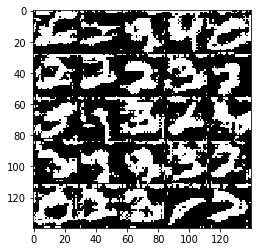

Epoch 2/2... Batch 1710... Discriminator Loss: 1.3716... Generator Loss: 0.7918


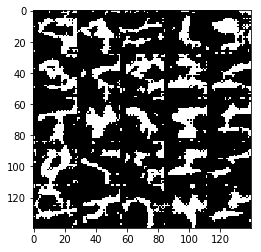

Epoch 2/2... Batch 1740... Discriminator Loss: 1.4107... Generator Loss: 0.7562


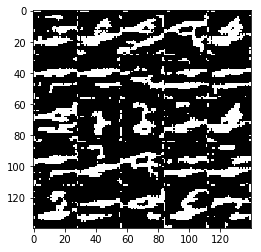

Epoch 2/2... Batch 1770... Discriminator Loss: 2.6906... Generator Loss: 0.0993


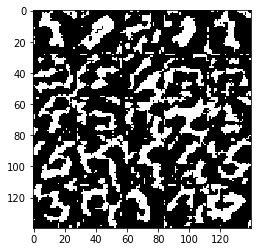

Epoch 2/2... Batch 1800... Discriminator Loss: 1.5425... Generator Loss: 0.4331


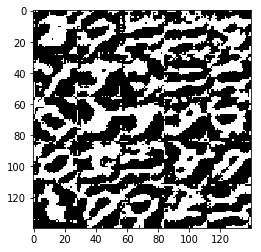

Epoch 2/2... Batch 1830... Discriminator Loss: 1.4006... Generator Loss: 0.8513


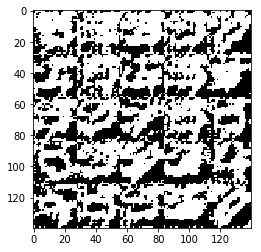

Epoch 2/2... Batch 1860... Discriminator Loss: 1.3945... Generator Loss: 0.7591


In [56]:
batch_size = 64
z_dim = 100
learning_rate = 0.02
beta1 = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

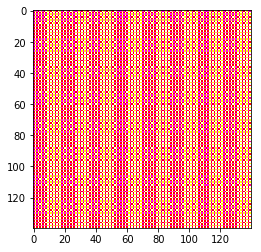

Epoch 1/1... Batch 0... Discriminator Loss: 29.4061... Generator Loss: 0.0000


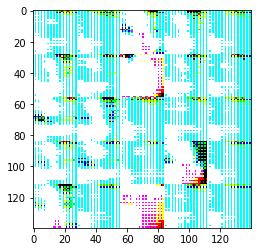

Epoch 1/1... Batch 30... Discriminator Loss: 2.2648... Generator Loss: 1.5385


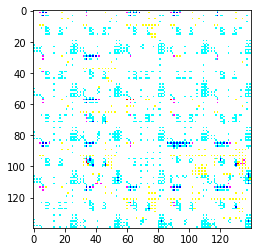

Epoch 1/1... Batch 60... Discriminator Loss: 1.3531... Generator Loss: 0.9471


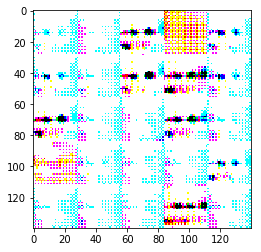

Epoch 1/1... Batch 90... Discriminator Loss: 1.8696... Generator Loss: 0.3085


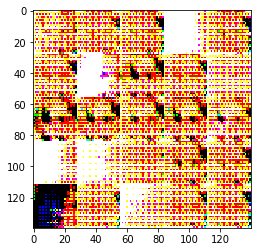

Epoch 1/1... Batch 120... Discriminator Loss: 1.3249... Generator Loss: 2.7937


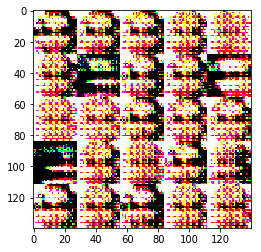

Epoch 1/1... Batch 150... Discriminator Loss: 1.1284... Generator Loss: 0.7621


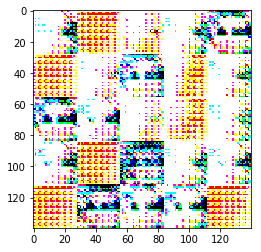

Epoch 1/1... Batch 180... Discriminator Loss: 1.3116... Generator Loss: 2.0996


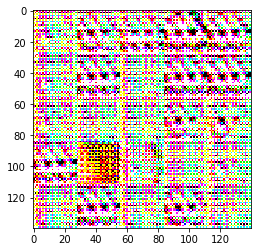

Epoch 1/1... Batch 210... Discriminator Loss: 0.4944... Generator Loss: 2.2218


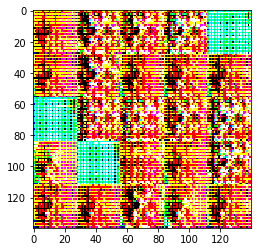

Epoch 1/1... Batch 240... Discriminator Loss: 1.3503... Generator Loss: 0.7368


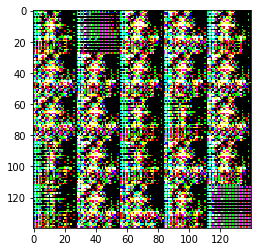

Epoch 1/1... Batch 270... Discriminator Loss: 0.3637... Generator Loss: 3.9657


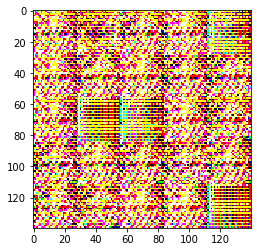

Epoch 1/1... Batch 300... Discriminator Loss: 2.0415... Generator Loss: 0.6340


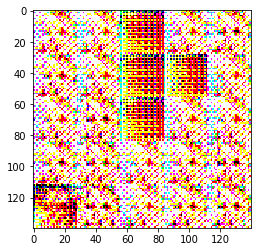

Epoch 1/1... Batch 330... Discriminator Loss: 1.3668... Generator Loss: 0.5357


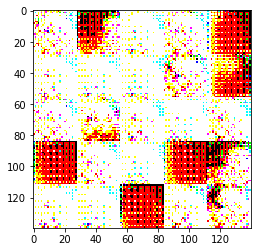

Epoch 1/1... Batch 360... Discriminator Loss: 1.0169... Generator Loss: 0.8116


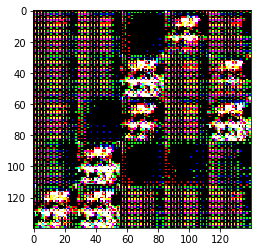

Epoch 1/1... Batch 390... Discriminator Loss: 0.4161... Generator Loss: 3.4728


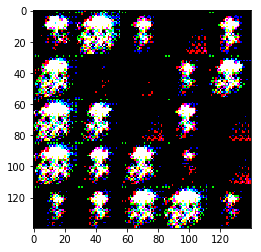

Epoch 1/1... Batch 420... Discriminator Loss: 1.3470... Generator Loss: 0.7455


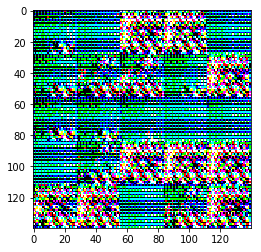

Epoch 1/1... Batch 450... Discriminator Loss: 0.3537... Generator Loss: 4.0727


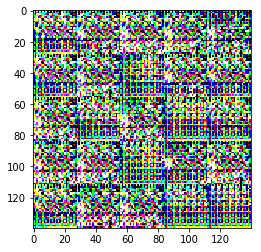

Epoch 1/1... Batch 480... Discriminator Loss: 0.3299... Generator Loss: 6.0651


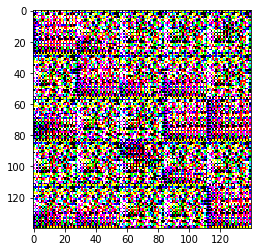

Epoch 1/1... Batch 510... Discriminator Loss: 0.3268... Generator Loss: 9.9723


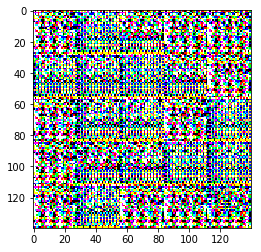

Epoch 1/1... Batch 540... Discriminator Loss: 0.3297... Generator Loss: 6.7077


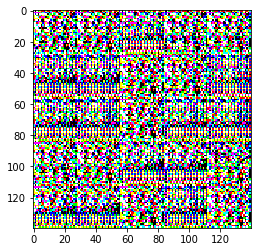

Epoch 1/1... Batch 570... Discriminator Loss: 0.3287... Generator Loss: 7.6599


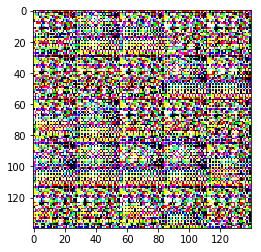

Epoch 1/1... Batch 600... Discriminator Loss: 0.3274... Generator Loss: 8.3453


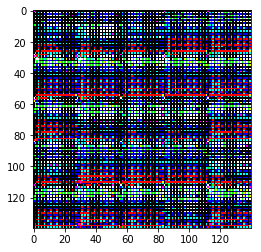

Epoch 1/1... Batch 630... Discriminator Loss: 0.3272... Generator Loss: 8.5071


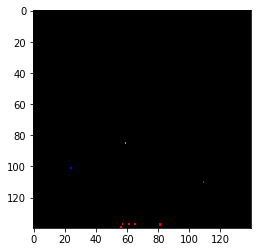

Epoch 1/1... Batch 660... Discriminator Loss: 0.3404... Generator Loss: 6.4888


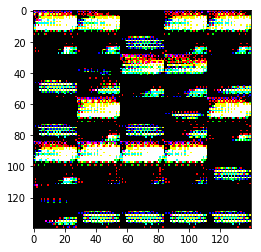

Epoch 1/1... Batch 690... Discriminator Loss: 0.4051... Generator Loss: 3.0309


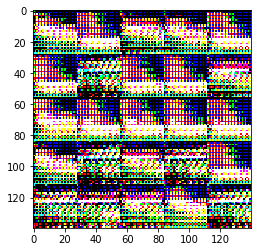

Epoch 1/1... Batch 720... Discriminator Loss: 0.3346... Generator Loss: 5.5385


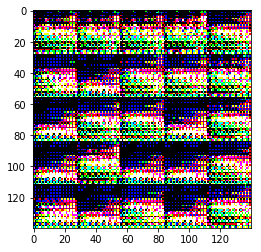

Epoch 1/1... Batch 750... Discriminator Loss: 0.3350... Generator Loss: 5.5862


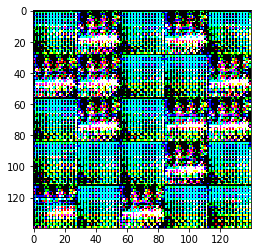

Epoch 1/1... Batch 780... Discriminator Loss: 0.5121... Generator Loss: 1.9437


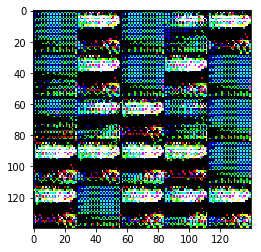

Epoch 1/1... Batch 810... Discriminator Loss: 0.3365... Generator Loss: 5.6610


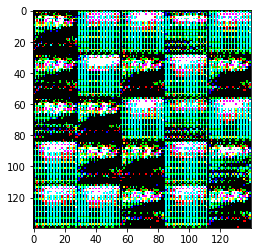

Epoch 1/1... Batch 840... Discriminator Loss: 0.3296... Generator Loss: 7.1461


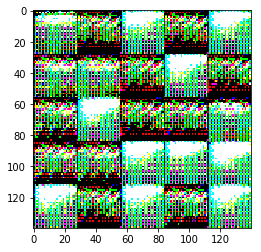

Epoch 1/1... Batch 870... Discriminator Loss: 0.3364... Generator Loss: 4.7999


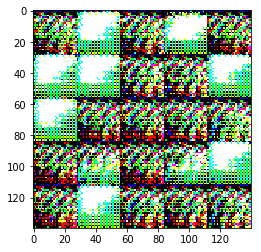

Epoch 1/1... Batch 900... Discriminator Loss: 0.3311... Generator Loss: 5.5180


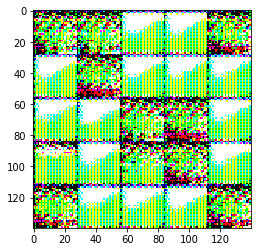

Epoch 1/1... Batch 930... Discriminator Loss: 0.3298... Generator Loss: 5.6404


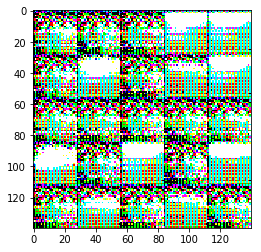

Epoch 1/1... Batch 960... Discriminator Loss: 0.3261... Generator Loss: 16.0639


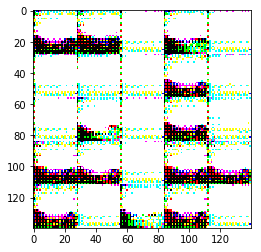

Epoch 1/1... Batch 990... Discriminator Loss: 0.3265... Generator Loss: 8.4794


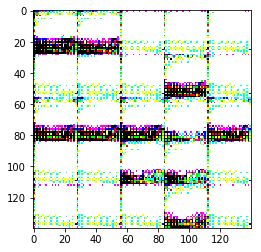

Epoch 1/1... Batch 1020... Discriminator Loss: 0.3263... Generator Loss: 8.5910


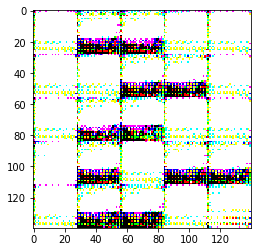

Epoch 1/1... Batch 1050... Discriminator Loss: 0.3256... Generator Loss: 8.6008


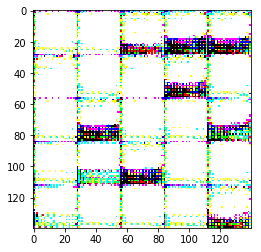

Epoch 1/1... Batch 1080... Discriminator Loss: 0.3262... Generator Loss: 8.6462


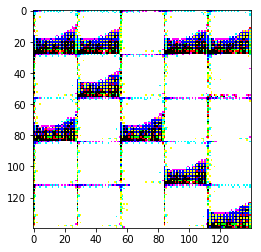

Epoch 1/1... Batch 1110... Discriminator Loss: 0.3328... Generator Loss: 8.4711


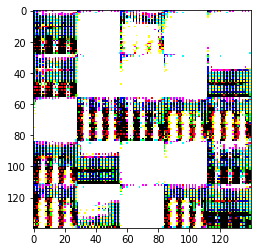

Epoch 1/1... Batch 1140... Discriminator Loss: 0.3271... Generator Loss: 7.1560


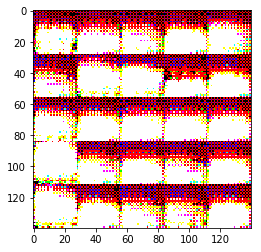

Epoch 1/1... Batch 1170... Discriminator Loss: 1.1993... Generator Loss: 1.2583


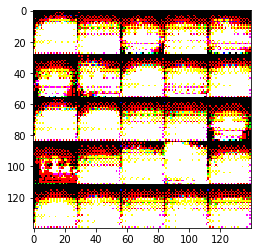

Epoch 1/1... Batch 1200... Discriminator Loss: 1.3247... Generator Loss: 0.9557


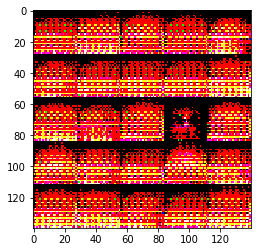

Epoch 1/1... Batch 1230... Discriminator Loss: 1.1720... Generator Loss: 1.4648


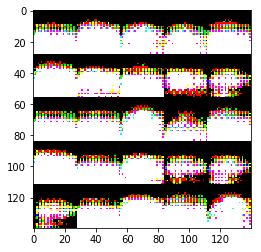

Epoch 1/1... Batch 1260... Discriminator Loss: 0.8552... Generator Loss: 1.7919


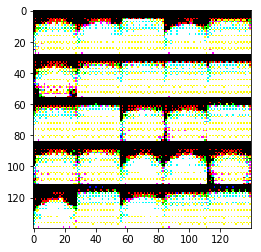

Epoch 1/1... Batch 1290... Discriminator Loss: 1.2901... Generator Loss: 0.8121


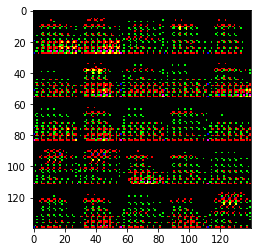

Epoch 1/1... Batch 1320... Discriminator Loss: 1.4222... Generator Loss: 0.5486


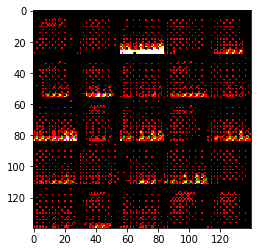

Epoch 1/1... Batch 1350... Discriminator Loss: 1.2577... Generator Loss: 0.8473


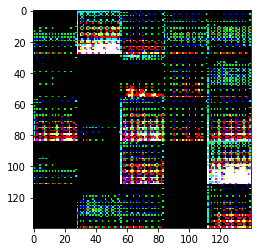

Epoch 1/1... Batch 1380... Discriminator Loss: 1.5056... Generator Loss: 0.7266


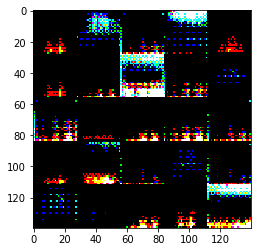

Epoch 1/1... Batch 1410... Discriminator Loss: 1.3595... Generator Loss: 0.8131


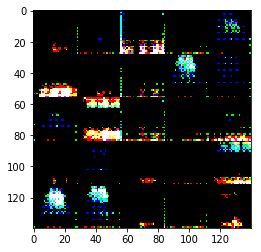

Epoch 1/1... Batch 1440... Discriminator Loss: 1.3624... Generator Loss: 0.7986


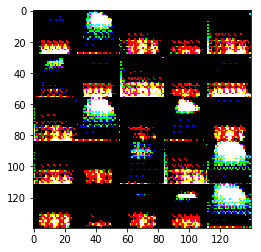

Epoch 1/1... Batch 1470... Discriminator Loss: 1.4123... Generator Loss: 0.7831


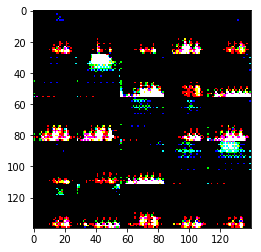

Epoch 1/1... Batch 1500... Discriminator Loss: 1.4619... Generator Loss: 0.7825


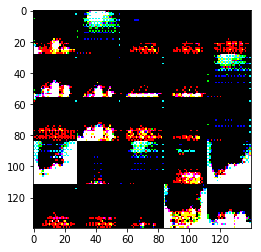

Epoch 1/1... Batch 1530... Discriminator Loss: 1.3723... Generator Loss: 0.8511


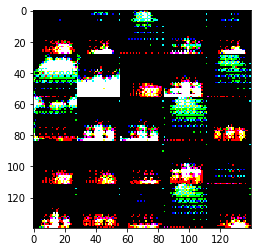

Epoch 1/1... Batch 1560... Discriminator Loss: 1.3591... Generator Loss: 0.7861


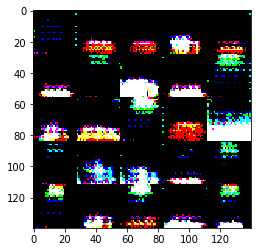

Epoch 1/1... Batch 1590... Discriminator Loss: 1.3989... Generator Loss: 0.8536


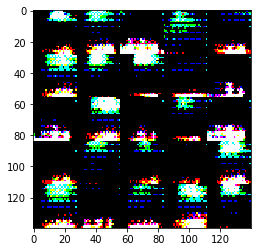

Epoch 1/1... Batch 1620... Discriminator Loss: 1.3876... Generator Loss: 0.8086


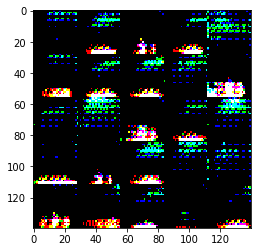

Epoch 1/1... Batch 1650... Discriminator Loss: 1.3742... Generator Loss: 0.7655


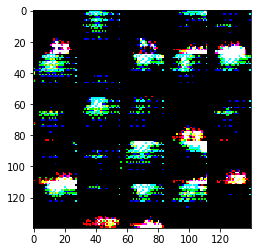

Epoch 1/1... Batch 1680... Discriminator Loss: 1.3909... Generator Loss: 0.7303


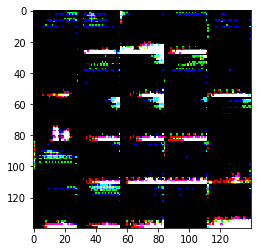

Epoch 1/1... Batch 1710... Discriminator Loss: 1.3857... Generator Loss: 0.8099


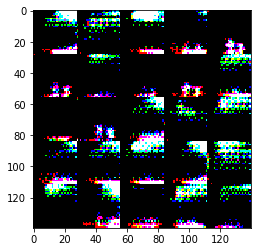

Epoch 1/1... Batch 1740... Discriminator Loss: 1.3789... Generator Loss: 0.7965


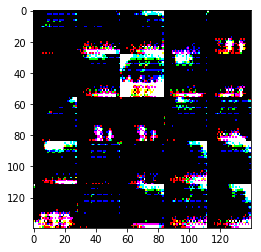

Epoch 1/1... Batch 1770... Discriminator Loss: 1.3848... Generator Loss: 0.7745


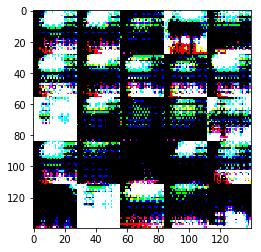

Epoch 1/1... Batch 1800... Discriminator Loss: 1.3741... Generator Loss: 0.7876


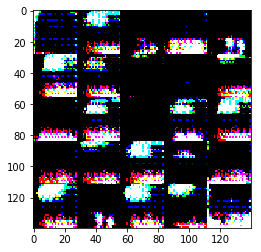

Epoch 1/1... Batch 1830... Discriminator Loss: 1.3774... Generator Loss: 0.7998


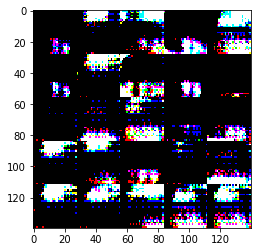

Epoch 1/1... Batch 1860... Discriminator Loss: 1.3741... Generator Loss: 0.8011


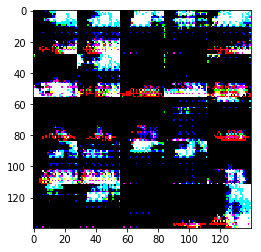

Epoch 1/1... Batch 1890... Discriminator Loss: 1.3806... Generator Loss: 0.7920


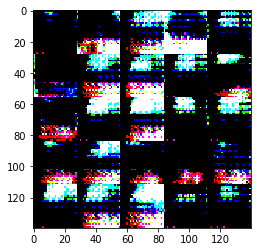

Epoch 1/1... Batch 1920... Discriminator Loss: 1.3759... Generator Loss: 0.7968


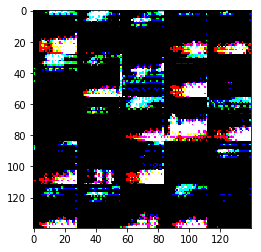

Epoch 1/1... Batch 1950... Discriminator Loss: 1.3750... Generator Loss: 0.7948


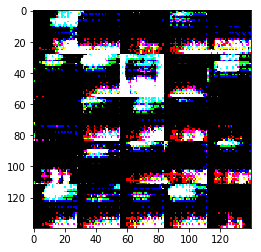

Epoch 1/1... Batch 1980... Discriminator Loss: 1.3753... Generator Loss: 0.8015


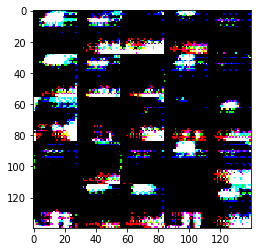

Epoch 1/1... Batch 2010... Discriminator Loss: 1.3762... Generator Loss: 0.8067


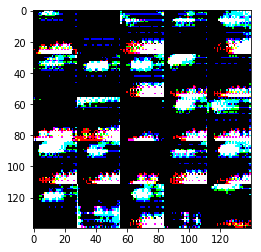

Epoch 1/1... Batch 2040... Discriminator Loss: 1.3805... Generator Loss: 0.7986


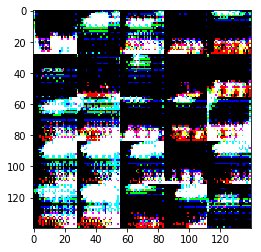

Epoch 1/1... Batch 2070... Discriminator Loss: 1.3788... Generator Loss: 0.8247


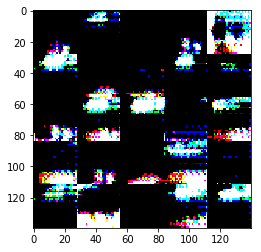

Epoch 1/1... Batch 2100... Discriminator Loss: 1.3783... Generator Loss: 0.8229


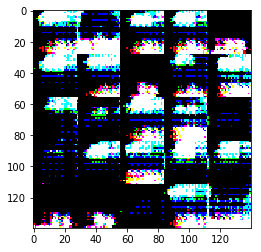

Epoch 1/1... Batch 2130... Discriminator Loss: 1.3792... Generator Loss: 0.8556


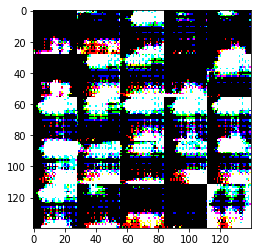

Epoch 1/1... Batch 2160... Discriminator Loss: 1.3767... Generator Loss: 0.8096


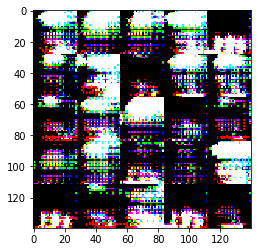

Epoch 1/1... Batch 2190... Discriminator Loss: 1.3757... Generator Loss: 0.7938


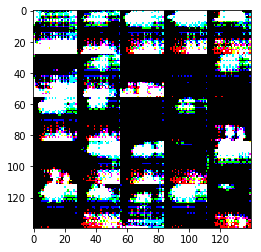

Epoch 1/1... Batch 2220... Discriminator Loss: 1.3759... Generator Loss: 0.8053


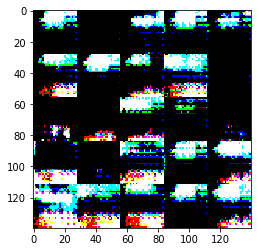

Epoch 1/1... Batch 2250... Discriminator Loss: 1.3778... Generator Loss: 0.8312


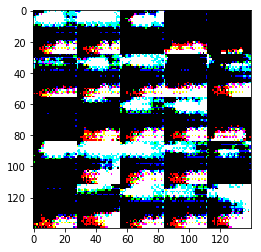

Epoch 1/1... Batch 2280... Discriminator Loss: 1.3763... Generator Loss: 0.8360


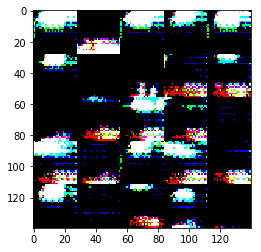

Epoch 1/1... Batch 2310... Discriminator Loss: 1.3769... Generator Loss: 0.8016


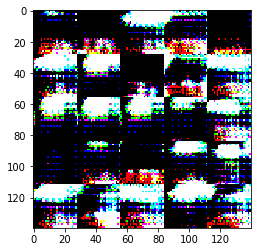

Epoch 1/1... Batch 2340... Discriminator Loss: 1.3765... Generator Loss: 0.8098


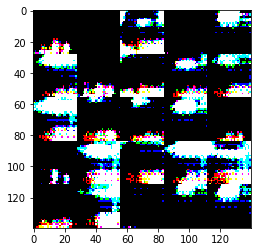

Epoch 1/1... Batch 2370... Discriminator Loss: 1.3770... Generator Loss: 0.7926


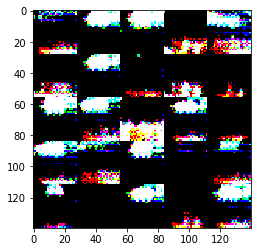

Epoch 1/1... Batch 2400... Discriminator Loss: 1.3852... Generator Loss: 0.8196


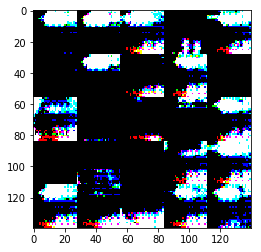

Epoch 1/1... Batch 2430... Discriminator Loss: 1.3791... Generator Loss: 0.8510


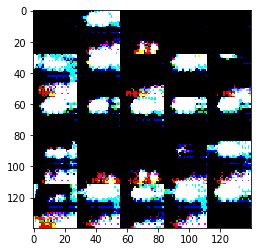

Epoch 1/1... Batch 2460... Discriminator Loss: 1.3758... Generator Loss: 0.8116


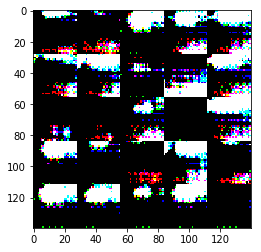

Epoch 1/1... Batch 2490... Discriminator Loss: 1.3774... Generator Loss: 0.7911


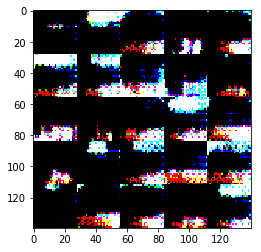

Epoch 1/1... Batch 2520... Discriminator Loss: 1.3768... Generator Loss: 0.7921


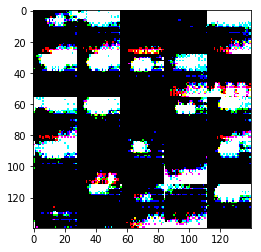

Epoch 1/1... Batch 2550... Discriminator Loss: 1.3784... Generator Loss: 0.7712


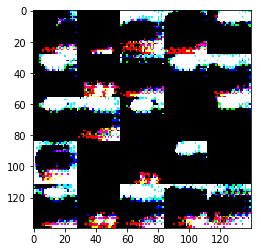

Epoch 1/1... Batch 2580... Discriminator Loss: 1.3774... Generator Loss: 0.7622


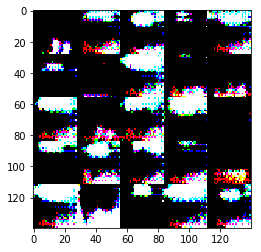

Epoch 1/1... Batch 2610... Discriminator Loss: 1.3770... Generator Loss: 0.7850


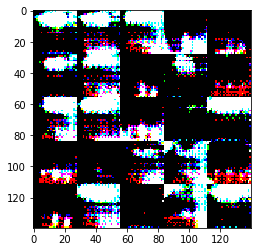

Epoch 1/1... Batch 2640... Discriminator Loss: 1.3774... Generator Loss: 0.7897


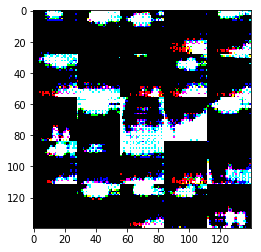

Epoch 1/1... Batch 2670... Discriminator Loss: 1.3764... Generator Loss: 0.7977


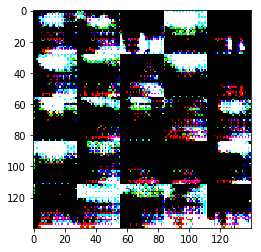

Epoch 1/1... Batch 2700... Discriminator Loss: 1.3772... Generator Loss: 0.7716


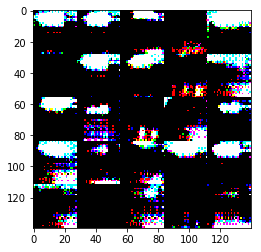

Epoch 1/1... Batch 2730... Discriminator Loss: 1.3786... Generator Loss: 0.7636


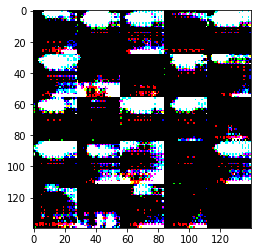

Epoch 1/1... Batch 2760... Discriminator Loss: 1.3764... Generator Loss: 0.7904


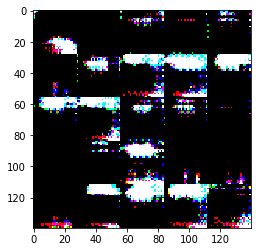

Epoch 1/1... Batch 2790... Discriminator Loss: 1.3766... Generator Loss: 0.7983


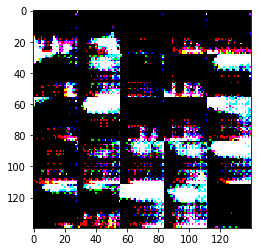

Epoch 1/1... Batch 2820... Discriminator Loss: 1.3764... Generator Loss: 0.7892


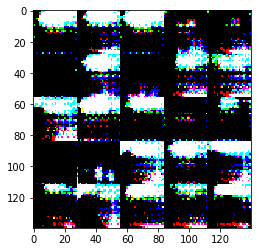

Epoch 1/1... Batch 2850... Discriminator Loss: 1.3777... Generator Loss: 0.7550


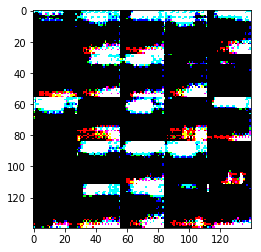

Epoch 1/1... Batch 2880... Discriminator Loss: 1.3770... Generator Loss: 0.7808


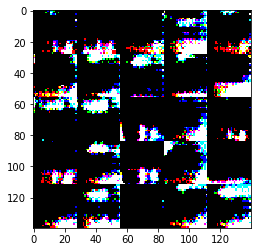

Epoch 1/1... Batch 2910... Discriminator Loss: 1.3763... Generator Loss: 0.7970


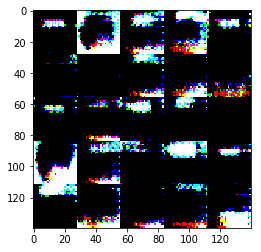

Epoch 1/1... Batch 2940... Discriminator Loss: 1.3762... Generator Loss: 0.7884


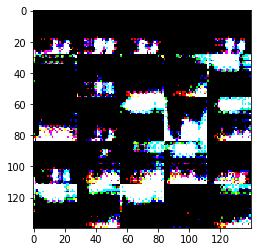

Epoch 1/1... Batch 2970... Discriminator Loss: 1.3785... Generator Loss: 0.7608


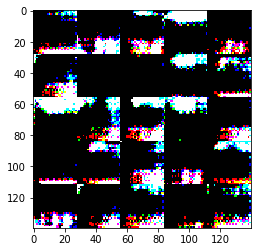

Epoch 1/1... Batch 3000... Discriminator Loss: 1.3777... Generator Loss: 0.7803


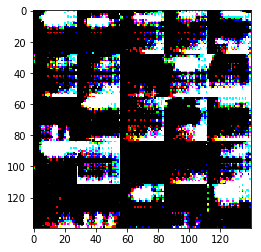

Epoch 1/1... Batch 3030... Discriminator Loss: 1.3772... Generator Loss: 0.7993


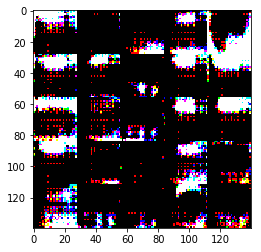

Epoch 1/1... Batch 3060... Discriminator Loss: 1.3769... Generator Loss: 0.7921


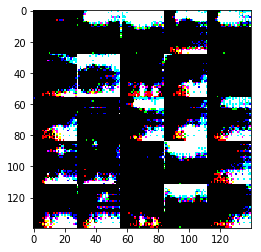

Epoch 1/1... Batch 3090... Discriminator Loss: 1.3771... Generator Loss: 0.7793


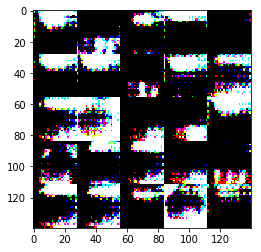

Epoch 1/1... Batch 3120... Discriminator Loss: 1.3775... Generator Loss: 0.7681


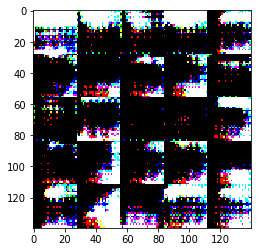

Epoch 1/1... Batch 3150... Discriminator Loss: 1.3766... Generator Loss: 0.7931


In [58]:
batch_size = 64
z_dim = 100
learning_rate = 0.02
beta1 = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.